In [1]:
!pip install git+https://github.com/mementum/backtrader.git@0fa63ef4a35dc53cc7320813f8b15480c8f85517#egg=backtrader


  Cloning https://github.com/mementum/backtrader.git (to revision 0fa63ef4a35dc53cc7320813f8b15480c8f85517) to c:\users\alex-\appdata\local\temp\pip-install-__rvr9yl\backtrader_256b1a5684ca45659d7d001d3d29f5f8
  Resolved https://github.com/mementum/backtrader.git to commit 0fa63ef4a35dc53cc7320813f8b15480c8f85517


  Running command git clone -q https://github.com/mementum/backtrader.git 'C:\Users\Alex-\AppData\Local\Temp\pip-install-__rvr9yl\backtrader_256b1a5684ca45659d7d001d3d29f5f8'
  Running command git rev-parse -q --verify 'sha^0fa63ef4a35dc53cc7320813f8b15480c8f85517'
  Running command git fetch -q https://github.com/mementum/backtrader.git 0fa63ef4a35dc53cc7320813f8b15480c8f85517
  Running command git checkout -q 0fa63ef4a35dc53cc7320813f8b15480c8f85517


In [2]:
import math
import backtrader as bt
import yfinance as yf
import mplfinance as mpf
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 6]

In [3]:
def get_yf_data(ticker="BTC-USD", interval="1d", period="max"): 
    ticker_yf = yf.Ticker(ticker)
    hist = ticker_yf.history(period=period, interval=interval)
    return bt.feeds.PandasData(dataname = hist)

In [4]:
class FixedCommisionScheme(bt.CommInfoBase):
    paras = (
        ('commission', 10),
        ('stocklike', True),
        ('commtype', bt.CommInfoBase.COMM_FIXED)
    )

    def _getcommission(self, size, price, pseudoexec):
        return self.p.commission

In [5]:
class BuyAndHold(bt.Strategy):
    def __init__(self):
        self.order = None
        self.totalcost = 0
        self.cost_wo_bro = 0
        self.units = 0
        self.times = 0
        
    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))
        
    def start(self):
        self.cash_start = self.broker.get_cash()

    def nextstart(self):
        size = math.floor( (self.broker.get_cash() - 10) / self.data[0] )
        self.buy(size=size)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price %.2f, Cost %.2f, Comm %.2f, Size %.0f' %
                    (order.executed.price,
                    order.executed.value,
                    order.executed.comm,
                    order.executed.size)
                )

                self.units += order.executed.size
                self.totalcost += order.executed.value + order.executed.comm
                self.cost_wo_bro += order.executed.value
                self.times += 1

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            print(order.status, [order.Canceled, order.Margin, order.Rejected])

        self.order = None

    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1
        self.froi = (self.broker.get_fundvalue() - self.cash_start)
        value = self.datas[0].close * self.units + self.broker.get_cash()
        print('-'*50)
        print('BUY and HOLD')
#         print('Time in Market: {:.1f} years'.format((endDate - actualStart).days/365))
        print('#Times:         {:.0f}'.format(self.times))
        print('Value:         ${:,.2f}'.format(value))
        print('Cost:          ${:,.2f}'.format(self.totalcost))
        print('Gross Return:  ${:,.2f}'.format(value - self.totalcost))
        print('Gross %:        {:.2f}%'.format((value/self.totalcost - 1) * 100))
        print('ROI:            {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value:     {:.2f}%'.format(self.froi))
#         print('Annualised:     {:.2f}%'.format(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1)))
        print('-'*50)

In [6]:
class BuyAndHold_More_Fund(bt.Strategy):
    params = dict(
        monthly_cash=1000,
        monthly_range=[5,20]
    )

    def __init__(self):
        self.order = None
        self.totalcost = 0
        self.cost_wo_bro = 0
        self.units = 0
        self.times = 0

    def log(self, txt, dt=None):
        dt = dt or self.datas[0].datetime.date(0)
        print('%s, %s' % (dt.isoformat(), txt))

    def start(self):
        self.broker.set_fundmode(fundmode=True, fundstartval=100.0)

        self.cash_start = self.broker.get_cash()
        self.val_start = 100.0

        # ADD A TIMER
        self.add_timer(
            when=bt.timer.SESSION_START,
            monthdays=[1],
            monthcarry=True
            # timername='buytimer',
        )

    def notify_timer(self, timer, when, *args):
        print(self.__dict__)
        self.broker.add_cash(self.p.monthly_cash)

        target_value = self.broker.get_value() + self.p.monthly_cash
        self.order_target_value(target=target_value)
        size = math.floor( (self.broker.get_cash()) / self.data[0] )
        self.buy(size=size)

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price %.2f, Cost %.2f, Comm %.2f, Size %.0f' %
                    (order.executed.price,
                    order.executed.value,
                    order.executed.comm,
                    order.executed.size)
                )

                self.units += order.executed.size
                self.totalcost += order.executed.value + order.executed.comm
                self.cost_wo_bro += order.executed.value
                self.times += 1

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
            print(order.status, [order.Canceled, order.Margin, order.Rejected])

        self.order = None

    def stop(self):
        # calculate actual returns
        self.roi = (self.broker.get_value() / self.cash_start) - 1
        self.froi = (self.broker.get_fundvalue() - self.cash_start)
        value = self.datas[0].close * self.units + self.broker.get_cash()
        print('-'*50)
        print('BUY & BUY MORE')
#         print('Time in Market: {:.1f} years'.format((endDate - actualStart).days/365))
        print('#Times:         {:.0f}'.format(self.times))
        print('Value:         ${:,.2f}'.format(value))
        print('Cost:          ${:,.2f}'.format(self.totalcost))
        print('Gross Return:  ${:,.2f}'.format(value - self.totalcost))
        print('Gross %:        {:.2f}%'.format((value/self.totalcost - 1) * 100))
        print('ROI:            {:.2f}%'.format(100.0 * self.roi))
        print('Fund Value:     {:.2f}%'.format(self.froi))
#         print('Annualised:     {:.2f}%'.format(100*((1+self.froi/100)**(365/(endDate - actualStart).days) - 1)))
        print('-'*50)

In [7]:
def test_strategy(data, strategy=None, initial_cash=1000):
    # BUY and HOLD
    cerebro = bt.Cerebro()
    cerebro.adddata(data)
    cerebro.addstrategy(strategy)

    # Broker Information
    broker_args = dict(coc=True)
    cerebro.broker = bt.brokers.BackBroker(**broker_args)
    comminfo = FixedCommisionScheme()
    cerebro.broker.addcommissioninfo(comminfo)

    cerebro.broker.set_cash(initial_cash)
    cerebro.run()
    cerebro.plot(iplot=True, style='candlestick')



2014-09-18, BUY EXECUTED, Price 457.33, Cost 914.67, Comm 0.00, Size 2
--------------------------------------------------
BUY and HOLD
#Times:         1
Value:         $71,934.39
Cost:          $914.67
Gross Return:  $71,019.73
Gross %:        7764.54%
ROI:            7093.44%
Fund Value:     6193.44%
--------------------------------------------------


<IPython.core.display.Javascript object>


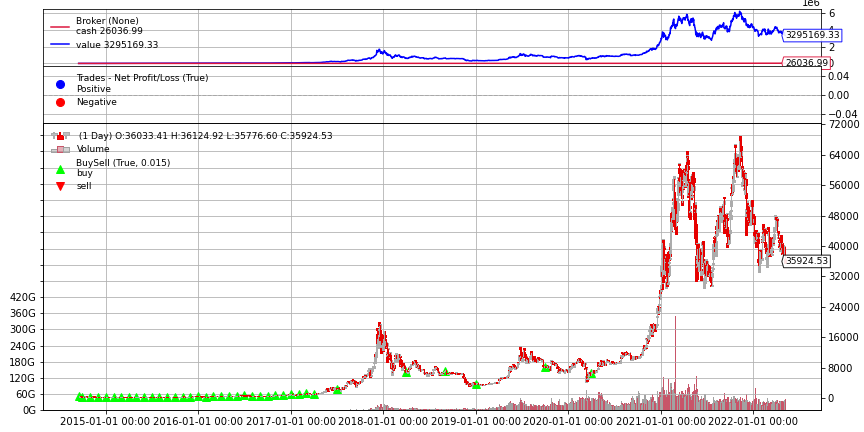

In [8]:
data = get_yf_data()
strategy = BuyAndHold
test_strategy(data, strategy=strategy)


In [9]:

strategy = BuyAndHold_More_Fund
test_strategy(data, strategy=strategy)

{'params': <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x000002154F955910>, 'p': <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x000002154F955910>, '_owner': None, 'plotinfo': <backtrader.metabase.AutoInfoClass_pi_LineSeries_pi_LineIterator_pi_DataAccessor_pi_StrategyBase_pi_Strategy_pi_BuyAndHold_More_Fund object at 0x000002154FDC0BE0>, 'lines': <backtrader.lineseries.Lines_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x000002154FA6C910>, 'plotlines': <backtrader.metabase.AutoInfoClass_pl_LineSeries_pl_LineIterator_pl_DataAccessor_pl_StrategyBase_pl_Strategy_pl_BuyAndHold_More_Fund object at 0x000002154F4FE790>, 'l': <backtrader.lineseries.Lines_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x0000

{'params': <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x000002154F955910>, 'p': <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x000002154F955910>, '_owner': None, 'plotinfo': <backtrader.metabase.AutoInfoClass_pi_LineSeries_pi_LineIterator_pi_DataAccessor_pi_StrategyBase_pi_Strategy_pi_BuyAndHold_More_Fund object at 0x000002154FDC0BE0>, 'lines': <backtrader.lineseries.Lines_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x000002154FA6C910>, 'plotlines': <backtrader.metabase.AutoInfoClass_pl_LineSeries_pl_LineIterator_pl_DataAccessor_pl_StrategyBase_pl_Strategy_pl_BuyAndHold_More_Fund object at 0x000002154F4FE790>, 'l': <backtrader.lineseries.Lines_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x0000

{'params': <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x000002154F955910>, 'p': <backtrader.metabase.AutoInfoClass_LineRoot_LineMultiple_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x000002154F955910>, '_owner': None, 'plotinfo': <backtrader.metabase.AutoInfoClass_pi_LineSeries_pi_LineIterator_pi_DataAccessor_pi_StrategyBase_pi_Strategy_pi_BuyAndHold_More_Fund object at 0x000002154FDC0BE0>, 'lines': <backtrader.lineseries.Lines_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x000002154FA6C910>, 'plotlines': <backtrader.metabase.AutoInfoClass_pl_LineSeries_pl_LineIterator_pl_DataAccessor_pl_StrategyBase_pl_Strategy_pl_BuyAndHold_More_Fund object at 0x000002154F4FE790>, 'l': <backtrader.lineseries.Lines_LineSeries_LineIterator_DataAccessor_StrategyBase_Strategy_BuyAndHold_More_Fund object at 0x0000